# Supplement 3: Code to Generate Figures

High-Precision characterisation of indicator dyes by Spectral Fitting: Application to Swawater pH and Alkalinity measurements. Branson & Ellwood. *In Review.*

This notebook contains code to generate figures that are not present in the other supplements.

## Figures
1. [Molal Absorption Spectra](#fig1)
2. [pH Determination by end-member fitting](#fig2)
3. See [S1: pH Determination by Spectral Fitting](https://nbviewer.jupyter.org/github/oscarbranson/carbspec/blob/master/SI/Spectral_Fitting.ipynb#fig3)
4. See [S2: Total Alkalinity Calculation from One-Point Titration¶](https://nbviewer.jupyter.org/github/oscarbranson/carbspec/blob/master/SI/TA_Calculation.ipynb#fig4)
5. See [S2: Total Alkalinity Calculation from One-Point Titration¶](https://nbviewer.jupyter.org/github/oscarbranson/carbspec/blob/master/SI/TA_Calculation.ipynb#fig5)
6. [Alkalinity Precision¶](#fig6)

In [1]:
import pandas as pd
import numpy as np
import cbsyst as cb
import matplotlib.pyplot as plt
import datetime as dt
import re
from glob import glob
import uncertainties as un
from uncertainties import unumpy as unp
from tqdm.notebook import tqdm

from carbspec.io import load_spectrum, load_spectra
from carbspec import spectro
from carbspec.alkalinity import calc_acid_strength, TA_from_pH
from carbspec import dye

# L&O plot specs
# https://aslopubs.onlinelibrary.wiley.com/hub/journal/15415856/about/author-guidelines#7
cw = 4  # column width = 3.5 inches
figpath = './figs/'

<a id="fig1"></a>
## Figure 1: Molal Absorption Spectra

Molal absorption of the acid ($\lambda \epsilon_{IH}$) and base ($\lambda \epsilon_{I}$) end-members for Metacresol Purple (MCP) and Bromophenol Blue (BPB) dyes used in spectral fitting.

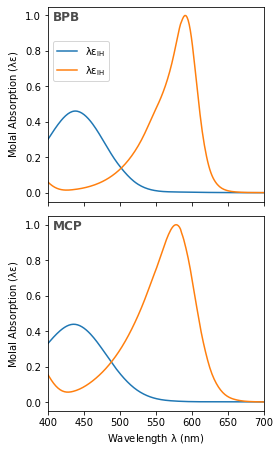

In [2]:
wv = np.linspace(400, 700, 200)
amcp, bmcp = dye.spline_handler('MCP')
abpb, bbpb = dye.spline_handler('BPB')

fig, axs = plt.subplots(2, 1, figsize=[cw, 1.6 * cw], sharex=True)

ax, ax2 = axs

ax.plot(wv, abpb(wv), color='C0', label='$\lambda \epsilon_{IH}$')
ax.plot(wv, bbpb(wv), c='C1', label='$\lambda \epsilon_{IH}$')
ax.legend(fontsize=10, bbox_to_anchor=(.0, .85), loc='upper left')
ax.text(.02, .98, 'BPB', weight='bold', ha='left', va='top', transform=ax.transAxes, fontsize=12, alpha=0.7)

ax2.plot(wv, amcp(wv), color='C0', label='$HI$')
ax2.plot(wv, bmcp(wv), c='C1', label='$I^-$')
ax2.text(.02, .98, 'MCP', weight='bold', ha='left', va='top', transform=ax2.transAxes, fontsize=12, alpha=0.7)

ax2.set_xlabel('Wavelength $\lambda$ (nm)')

for ax in axs:
    ax.set_ylabel('Molal Absorption ($\lambda \epsilon$)')
    ax.set_xlim(400, 700)

fig.tight_layout()

fig.savefig(figpath + '1_molal_abs.pdf')

<a id="fig1"></a>
## Figure 2: pH Determination by end-member fitting

Illustrated on field-collected spectra. (A) A least-squares end-member fit to MCP dye in an an aliquot of a newly-opened Dickson CRM 178, with (B) the fit residuals demonstrating the model goodness-of-fit. Seven repeat measurements of the same CRM (C) reveal the accuracy ($\mu = 0.005$) and precision ($\sigma = 0.002$) of the technique under field operating conditions. The $\mathrm{pH_T}$ of the CRM is calculated from reported TA and DIC values using cbsyst \citep{cbsyst036}. Uncertainties ($1\sigma$) of individual measurements are within the size of the data points.}

In [3]:
# CRM info
CRMs = {
    178: {
        'sal': 33.782,
        'TA': un.ufloat(2216.53, 0.61),
        'DIC': un.ufloat(1952.65, 0.31),
        'TP': 0.39,
        'TSi': 2.5
    },
    140: {
        'sal': 33.471,
        'TA': un.ufloat(2232.58, 0.8),
        'DIC': un.ufloat(2040.94, 0.41),
        'TP': 0.49,
        'TSi': 2.5
    }
}

In [4]:
pH_spec = load_spectra('data/pH/')  # repeat measurement of freshly opened Dickson CRM 178

crm = 178
pHs_calced = []
pHs_meas = []
fits = []
for k, v in pH_spec.items():
    pHs_calced.append(cb.Csys(DIC=un.nominal_value(CRMs[crm]['DIC']), TA=un.nominal_value(CRMs[crm]['TA']), 
                              TP=CRMs[crm]['TP'], TSi=CRMs[crm]['TSi'], 
                              S_in=CRMs[crm]['sal'], T_in=v['Temperature'][0]).pHtot[0])
    fits.append(spectro.unmix_spectra(v['wavelength'], v['Abs'], dye='MCP'))
    pHs_meas.append(spectro.pH_from_spectrum(v['wavelength'], v['Abs'], dye='MCP', temp=v['Temperature'][0], sal=CRMs[crm]['sal']))

pHs_calced = np.array(pHs_calced)
pHs_meas = np.array(pHs_meas)

diff = unp.nominal_values(pHs_calced - pHs_meas)

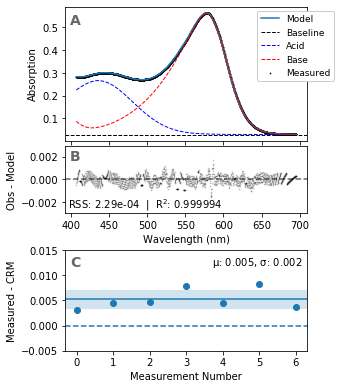

In [5]:
i = 3  # choose which spectrum to plot (they're all very similar!)
k = list(pH_spec.keys())[i]
v = pH_spec[k]
fit = fits[i]

fig, axs = spectro.plot_mixture(v['wavelength'], v['Abs'], 'MCP', fit[0])
fig.set_size_inches([cw * 1.2, cw * 7 / 5])

gs = plt.GridSpec(4, 1, fig, height_ratios=[2,1,0.4,1.5], left=0.22, right=0.92)

sax, eax = axs

sax.set_position(gs[0].get_position(fig))
eax.set_position(gs[1].get_position(fig))

sax.legend(fontsize=9, bbox_to_anchor=(.63, .4, .5, .6), framealpha=1)

rax = fig.add_axes(gs[3].get_position(fig))
rax.scatter(np.arange(0, len(pHs_calced)), unp.nominal_values(diff))
rax.axhline(0, ls='dashed')
rax.axhline(diff.mean())
rax.axhspan(diff.mean() - diff.std(), diff.mean() + diff.std(), alpha=0.2)

rax.set_ylim(-0.005, 0.015)
rax.set_ylabel('Measured - CRM')
rax.set_xlabel('Measurement Number')

rax.text(.98, .95, f'$\mu$: {diff.mean():.3f}, $\sigma$: {diff.std():.3f}', va='top', ha='right', transform=rax.transAxes)

for ax, lab in zip([sax, eax, rax], 'ABC'):
    ax.text(0.02, 0.95, lab, ha='left', va='top', transform=ax.transAxes, color=(.4,.4,.4), weight='bold', fontsize=14)

fig.savefig(figpath + '2_specfit.pdf')

<a id="fig6"></a>
## Figure 6: Alkalinity Precision

Field measurements of Dickson CRMs 140 and 178 across collected over two years of analyses. Colours represent sets of samples measured with the same acid.

In [6]:
# read auxilliary data - bottle weights, temp, sal
aux = pd.read_csv('data/Alk/Alk_auxillary.csv', parse_dates=['datetime'], dayfirst=True)
aux.sort_values('datetime', inplace=True)
aux.reset_index(drop=True, inplace=True)
aux.dropna(inplace=True)

In [7]:
# create dict linking auxilliary entries to spectra data
specfiles = glob('data/Alk/raw/*.dat')

datematch = re.compile('.*([0-9]{6}_[0-9]{2}_[0-9]{2}_[0-9]{4}).dat')
fstr = '%H%M%S_%d_%m_%Y'
datematch2 = re.compile('.*([0-9]{4}_[0-9]{8}).dat')
fstr2 = '%H%M_%d%m%Y'

times = []
for f in specfiles:
    try:
        t = dt.datetime.strptime(datematch.findall(f)[0], fstr)
    except IndexError:
        t = dt.datetime.strptime(datematch2.findall(f)[0], fstr2)
    times.append(t)

fdict = dict(zip(times, specfiles))

# parse file dates
aux.loc[:, 'dt'] = None
for i, r in aux.iterrows():
    dti = r.datetime
    if dti not in fdict:
        dti = r.datetime.to_pydatetime().replace(second=0)
    if dti in fdict:
        aux.loc[i, 'dt'] = dti

In [8]:
# load spectra
spectra = {}
for i, r in aux.iterrows():
    if r.loc['dt'] in fdict:
        fname = fdict[r.loc['dt']]
        spectra[i] = load_spectrum(fname, 410, 690)

# calculate pH
for k, s in spectra.items():
    wv = s['wavelength']
    A = s['Abs']
    aux.loc[k, 'pH'] = spectro.pH_from_spectrum(wv, A, dye='BPB', temp=aux.loc[k, 'temp'], sal=aux.loc[k, 'salinity'])
aux.dropna(subset=['pH'], inplace=True)

In [9]:
# calibrate acid strength against CRM (treat each acid batch separately)
for s, g in tqdm(aux.groupby(['Set', 'Acid'])):
    ind = (aux.Set == s[0]) & (aux.Acid == s[1])
    aux.loc[ind, 'acid_str'] = calc_acid_strength(CRMs[g.CRM.iloc[0]]['TA'], g.pH, g.m0, g.m, g.salinity, g.temp)
    aux.loc[ind, 'TA_ref'] = CRMs[g.CRM.iloc[0]]['TA']

In [10]:
# calculate TA
aux.loc[:, 'TA'] = TA_from_pH(aux.pH, aux.m0, aux.m, aux.salinity, aux.temp, aux.acid_str) * 1e6

In [11]:
# calculate per-sample means
def umean(g):
    labcols = ['SampleID', 'datetime', 'dt', 'TA_ref', 'acid_str', 'salinity', 'm0',
               'm', 'CRM', 'Acid', 'Set']
    ecols = ['pH', 'temp', 'TA']
    out = pd.DataFrame(columns=g.columns, index=[g.index.values[0]])
    
    if g.shape[0] > 1:
        out.loc[:, ecols] = unp.uarray(unp.nominal_values(g.loc[:, ecols]).mean(0), unp.nominal_values(g.loc[:, ecols]).std(0))
    else:
        out.loc[:, ecols] = g.loc[:, ecols]
    out.loc[:, labcols] = g.loc[:, labcols].iloc[0].values
    
    return out

maux = aux.groupby('m0').apply(umean)
maux.loc[:, 'TA_diff'] = maux.loc[:, 'TA'] - maux.loc[:, 'TA_ref']
maux = maux.sort_values('datetime').reset_index(drop=True)

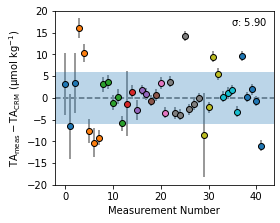

In [12]:
fig = plt.figure(figsize=(cw, 0.8 * cw))
x = maux.index.values
for s in maux.Set.unique():
    ind = maux.Set == s
    plt.scatter(x[ind], unp.nominal_values(maux.loc[ind, 'TA_diff']), edgecolors='k')
plt.errorbar(x, unp.nominal_values(maux.TA_diff), unp.std_devs(maux.TA_diff) * 1.96 , lw=0, elinewidth=2, color=(.6,.6,.6), zorder=-1)

plt.xlabel('Measurement Number')
plt.ylabel('$TA_{meas} - TA_{CRM}\ (\mu mol\ kg^{-1})$')

dmean = np.mean(unp.nominal_values(maux.loc[:, 'TA_diff']))
dstd = np.std(unp.nominal_values(maux.loc[:, 'TA_diff']))

ax = plt.gca()
xlim = ax.get_xlim()
ax.set_xlim(xlim)
ylim = ax.get_ylim()

plt.axhspan(-dstd, dstd, zorder=-1, alpha=0.3)
plt.axhline(0, ls='dashed', c='k', alpha=0.6, zorder=-2)
plt.text(0.97, 0.97, f'$\sigma$: {dstd:.2f}', transform=ax.transAxes, ha='right', va='top')
plt.ylim(-20, 20)

fig.tight_layout()

fig.savefig(figpath + '6_precision_TA.pdf')